# **EXPERIMENT 4**

Data: DailyDialog, Emotion-Stimulus, ISEAR 

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
import urllib.request
import zipfile
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download data

In [ ]:
emotion_list = ['neutral',
                'anger',
                'disgust',
                'fear',
                'joy',
                'sadness',
                'surprise',
                'shame',
                'guilt']

# DailyDialog
daily_dialog = pd.read_csv('../data/raw-data/dailydialog.csv', encoding='utf-8')
daily_dialog['Emotion'].replace({0:'neutral', 1:'anger', 2:'disgust', 3:'fear', 4:'joy', 5:'sadness', 6:'surprise'}, inplace=True)

# Emotion-Stimulus
emotion_stimulus = pd.read_csv('../data/raw-data/emotion-stimulus.csv', encoding='utf-8')
emotion_stimulus['Emotion'].replace({'happy':'joy', 'sad':'sadness'}, inplace=True)

# ISEAR
isear = pd.read_csv('../data/raw-data/isear.csv', encoding='utf-8')

# === Debug ===
df = daily_dialog.append(emotion_stimulus).append(isear)
display(df.head())
print(df.shape)
print(df.Emotion.value_counts())
df.loc[df['Emotion'] == 'guilt']


Emotion                                               Text
0  neutral  Say , Jim , how about going for a few beers af...
1  neutral   You know that is tempting but is really not g...
2  neutral     What do you mean ? It will help us to relax . 
3  neutral   Do you really think so ? I don't . It will ju...
4  neutral   I guess you are right.But what shall we do ? ...

(112866, 2)
neutral     85572
joy         14445
sadness      2792
anger        2576
surprise     2036
fear         1678
disgust      1515
shame        1200
guilt        1052
Name: Emotion, dtype: int64


Emotion                                               Text
6      guilt  When I caused problems for somebody because he...
13     guilt  When my uncle and my neighbour came home under...
19     guilt  I feel guilty when when I realize that I consi...
26     guilt  When I think that I do not study enough.  Afte...
33     guilt  When one has neglected or been unjust to a goo...
...      ...                                                ...
7444   guilt                                           Peeping.
7451   guilt  There were old people in a crowded bus and I d...
7458   guilt  In the past I used to think that my mother was...
7465   guilt                  I lied to one of my best friends.
7472   guilt  I had shouted at my younger brother and he was...

[1052 rows x 2 columns]

In [ ]:
df_no_joy_or_neutral = df[~df['Emotion'].isin(['joy', 'neutral', 'shame', 'guilt'])]
print(df_no_joy_or_neutral.shape)
print(df_no_joy_or_neutral.Emotion.value_counts())

NUM_SAMPLES = round(sum(df_no_joy_or_neutral.Emotion.value_counts()) / len(df_no_joy_or_neutral.Emotion.value_counts()))
df_joy = df[df['Emotion'] == 'joy'].sample(n=NUM_SAMPLES, random_state=1)
df_neutral = df[df['Emotion'] == 'neutral'].sample(n=NUM_SAMPLES, random_state=1)

df_balanced = df_joy.append(df_neutral).append(df_no_joy_or_neutral)
print(df_balanced.Emotion.value_counts())

(10597, 2)
sadness     2792
anger       2576
surprise    2036
fear        1678
disgust     1515
Name: Emotion, dtype: int64
sadness     2792
anger       2576
neutral     2119
joy         2119
surprise    2036
fear        1678
disgust     1515
Name: Emotion, dtype: int64


## Data Preprocessing

In [ ]:
num_classes = 7
embed_num_dims = 300
max_seq_len = 500

class_names = ['neutral', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [ ]:
data_train, data_test = train_test_split(df_balanced, test_size=0.20, random_state=42)

X_train = data_train.Text
X_test = data_test.Text
y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = data.lower()
    
    data = word_tokenize(data)
    
    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)
index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

In [ ]:
encoding = {'neutral': 0, 
            'anger': 1, 
            'disgust': 2, 
            'fear': 3, 
            'joy': 4, 
            'sadness': 5, 
            'surprise': 6}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Word Embeddings

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)

Unzipping...
done.


In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

## Model

In [ ]:
gru_output_size = 128

embedd_layer = Embedding(vocab_size, embed_num_dims, input_length = max_seq_len, weights = [embedd_matrix], trainable=False)
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(GRU(units=gru_output_size, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3986700   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 7)                 1799      
                                                                 
Total params: 4,318,739
Trainable params: 332,039
Non-trainable params: 3,986,700
_________________________________________________________________


## Training

In [ ]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train,  batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad,y_test))

Epoch 1/15
93/93 [==============================] - 738s 8s/step - loss: 1.7188 - accuracy: 0.3104 - val_loss: 1.5324 - val_accuracy: 0.4169
Epoch 2/15
93/93 [==============================] - 736s 8s/step - loss: 1.3799 - accuracy: 0.4870 - val_loss: 1.2671 - val_accuracy: 0.5349
Epoch 3/15
93/93 [==============================] - 743s 8s/step - loss: 1.1853 - accuracy: 0.5756 - val_loss: 1.1691 - val_accuracy: 0.5770
Epoch 4/15
93/93 [==============================] - 737s 8s/step - loss: 1.0866 - accuracy: 0.6143 - val_loss: 1.0888 - val_accuracy: 0.6151
Epoch 5/15
93/93 [==============================] - 738s 8s/step - loss: 1.0070 - accuracy: 0.6476 - val_loss: 1.0435 - val_accuracy: 0.6225
Epoch 6/15
93/93 [==============================] - 740s 8s/step - loss: 0.9676 - accuracy: 0.6589 - val_loss: 1.0148 - val_accuracy: 0.6367
Epoch 7/15
93/93 [==============================] - 731s 8s/step - loss: 0.9446 - accuracy: 0.6673 - val_loss: 0.9957 - val_accuracy: 0.6424
Epoch 8/15
93

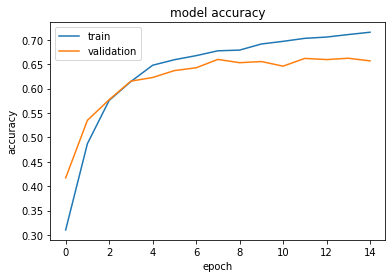

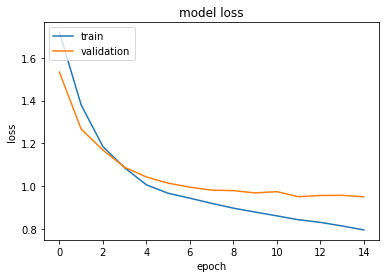

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 65.66%

F1 Score: 65.66


## Testing

In [ ]:
for x in X_test:
    print(x)
    print(X_test.iloc(0)[0])
    print('Message: {}\nPredicted: {}'.format(x, predictions[0]))
    break

 I've been trying to call him for the last ten minutes , but your line was busy . Will he be back soon ? 
 I've been trying to call him for the last ten minutes , but your line was busy . Will he be back soon ? 
Message:  I've been trying to call him for the last ten minutes , but your line was busy . Will he be back soon ? 
Predicted: anger


## Done

In [ ]:
model.save('./exp-4/models/biLSTM-w2v')

INFO:tensorflow:Assets written to: ./drive/MyDrive/eecs595-final-project/exp-4/models/biLSTM-w2v/assets


In [ ]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('./exp-4/models/biLSTM-w2v')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3986700   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 7)                 1799      
                                                                 
Total params: 4,318,739
Trainable params: 332,039
Non-trainable params: 3,986,700
_________________________________________________________________
